# Initialization

In [1]:
%matplotlib inline
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.stats import norm

pd.options.display.mpl_style = 'default'

In [2]:
# Get to the right working dir
os.chdir('C:\Users\Lewis\Documents\GitHub\dqn4wirelesscontrol')

# Data ingestion

In [3]:
# Detour: Generate a small sample file for testing purpose
sampleFile = open('./data/net_traffic_nonull_sample.dat', 'wb')
with open('./data/net_traffic_nonull.dat', 'rb') as trafficFile:
    trafficReader = csv.reader(trafficFile, delimiter=',')
    LIMIT = 1000
    cnt = 0
    for line in trafficReader:
        cnt += 1
        if cnt > LIMIT:
            break
        else:
            sampleFile.write(','.join(line)+'\n')        
sampleFile.close()

In [12]:
# Extract data from file and save into pd.DataFrame
session_df = pd.read_csv(filepath_or_buffer='./data/net_traffic_nonull_sample.dat', sep=',',
                        names=['uid','location','startT','duration','provider','type','domain','bytes','requests'])
session_df.index.name = 'sessionID'
session_df

,uid,location,startT,duration,provider,type,domain,bytes,requests
sessionID,,,,,,,,,
0,11000752,东中院二区,1411439886390,14799,百度1,搜索导航,baidu.com,2182,2
1,11000752,东中院二区,1411442145178,203010,网易;百度1;谷歌广告1;126网易免费邮箱;谷歌分析;谷歌链接;谷歌搜索2;个性化谷歌广告...,门户;搜索导航;广告;电子邮箱;数码科技;搜索导航;搜索导航;广告;电子邮箱;门户,163.com;baidu.com;doubleclick.net;126.com;goog...,261571;172538;34719;33058;18386;12952;1668;142...,39;33;5;5;2;2;1;1;1;1
2,11000752,东中院三区,1411442842421,0,腾讯微信,即时通讯,qq.com,395,1
3,11000752,学生事务中心-铁生馆,1411443156277,6523,百度1,搜索导航,baidu.com,15887,2
4,11000752,学生宿舍W,1411573440149,55,腾讯微信,即时通讯,qq.com,1150,1
5,11000752,东中院二区,1411956941699,335969,百度1;携程;携程;谷歌搜索2;谷歌分析;腾讯微信;谷歌广告1,搜索导航;旅游;旅游;搜索导航;数码科技;即时通讯;广告,baidu.com;c-ctrip.com;ctrip.com;google.com.hk;...,248455;132759;107146;13408;12705;3533;2260,88;29;13;13;3;3;2
6,11000752,东中院二区,1411957618285,301945,谷歌分析;accu天气,数码科技;生活工具,google-analytics.com;accu-weather.com,26382;20351,4;2
7,11000752,媒体与设计实验室B楼,1413176420667,3230202,百度1;百度图片服务器;风行网络电影;谷歌链接;微软;淘宝图片服务器1;acs86广告;谷歌...,搜索导航;图片服务;视频;搜索导航;数码科技;图片服务;广告;数码科技;广告;音乐;广告;门户,baidu.com;bdimg.com;funshion.com;googlesyndica...,2594141;1069598;201505;201155;114082;113645;15...,279;75;48;6;14;6;6;4;1;4;1;1
8,11000752,媒体与设计实验室B楼,1413180046636,1296008,百度1;微软;谷歌广告1;谷歌广告2;谷歌链接;个性化谷歌广告;千千音乐在线,搜索导航;数码科技;广告;广告;搜索导航;广告;音乐,baidu.com;microsoft.com;doubleclick.net;google...,68580;15576;11197;5689;3780;1679;1308,22;2;1;4;3;2;3


In [5]:
# Convert column formats
session_df['startT'] = pd.to_datetime(session_df['startT'], unit='ms')  # convert start time to readible date_time strings
session_df['duration'] = session_df['duration']/1000.0  # convert duration unit to seconds
session_df['totalBytes'] = session_df['bytes'].apply(lambda x: x.split(';')).map(lambda x: sum(map(float, x)))  # sum bytes across domains
session_df['totalRequest'] = session_df['requests'].apply(lambda x: x.split(';')).map(lambda x: sum(map(float, x)))  # sum requests across domains

#Aggregation analysis 

In [6]:
# Aggregate by LocName and see total duration, bytes, and requests
grouped_session_df = session_df[['location','duration', 'totalBytes', 'totalRequest']].groupby(['location'])

## Distribution of aggregated column values by location

Emperical Distributions:


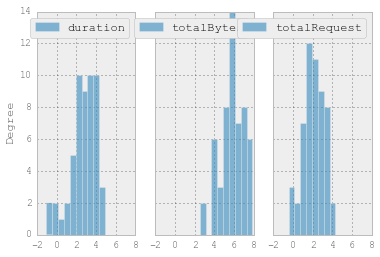

In [7]:
# Visulize emperical distribution (after log) from hist curve
print "Emperical Distributions:"
plt.figure()
sumByLocation = grouped_session_df.sum()
ax = np.log10(sumByLocation).plot(kind='hist', alpha=0.6, bins=15, subplots=True, layout=(1,3), sharex=True, sharey=True)
plt.show()
# ! Varies several OoM ( 6 for duration, 5 for totalBytes, 4 for totalRequests)
# Visualize the rank-size ditributiono

Rank-Size Distributions:
Index([u'第三食堂', u'东上院', u'东下院', u'第二食堂', u'东中院二区', u'媒体与设计实验室B楼',
       u'农学生物学院-附楼三', u'null', u'农学生物学院-附楼二', u'新体育馆-近沧源路', u'菁菁堂', u'学生宿舍W',
       u'工程力学实验中心', u'第一食堂', u'文选医学楼', u'外语楼', u'学生宿舍D', u'陈瑞球北楼', u'逸夫科技楼',
       u'徐汇新上院', u'学生服务中心', u'伍威权堂', u'东中院四区', u'棒球场', u'陈瑞球楼', u'东中院一区',
       u'徐汇体育馆', u'第四食堂', u'校医院北楼', u'建筑馆', u'农学生物学院-附楼一', u'材料A楼', u'药学楼4号楼',
       u'老行政楼', u'东中院三区', u'学生宿舍X', u'药学楼1号楼', u'校医院南楼', u'电信群楼1号楼',
       u'分析测试中心1号楼', u'学生宿舍', u'西南体育馆-南体', u'程及美术馆', u'西中院', u'图书馆四区', u'西下院',
       u'分析测试中心2号楼', u'凯旋门-待定', u'学生事务中心-铁生馆', u'机械与动力工程学院', u'媒体与设计实验室A楼',
       u'光彪楼', u'包玉刚图书馆', u'基建处'],
      dtype='object', name=u'location')
Index([u'第三食堂', u'东下院', u'第二食堂', u'媒体与设计实验室B楼', u'东上院', u'东中院二区',
       u'农学生物学院-附楼三', u'null', u'第一食堂', u'菁菁堂', u'农学生物学院-附楼二', u'文选医学楼',
       u'陈瑞球楼', u'工程力学实验中心', u'外语楼', u'学生宿舍W', u'陈瑞球北楼', u'新体育馆-近沧源路', u'材料A楼',
       u'学生宿舍D', u'徐汇新上院', u'东中院四区', u'分析测试中心1号楼', u'学生服务中心', u'伍威权堂',
       u'农学生

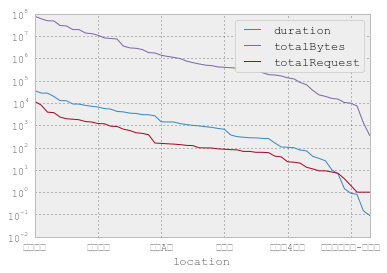

In [8]:
print "Rank-Size Distributions:"
plt.figure()
for i, index in enumerate(['duration', 'totalBytes', 'totalRequest']):
#     plt.subplot(1,3,i+1)
    sorted_copy = sumByLocation[index].copy()
    sorted_copy.sort(ascending=False)
    ax = sorted_copy.plot(x=pd.Series(range(len(sorted_copy.index))),logy=True)
    ax.set_ylim([10**(-2), 10**8])
    print sorted_copy.index
ax.legend(['duration', 'totalBytes', 'totalRequest'])
plt.show()
# ! Q: Follows to Zipf's law？ A: no, Zipf's is a straight line in log-log plot, here is a curvy curve
# ! Looks more like a exponential distribution with super-exp tail

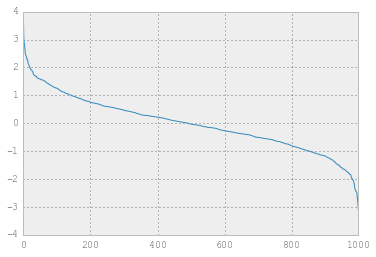

In [9]:
# Detour：What is the ranked plot of a series of normally distributed rvs
norm_sample = pd.Series(data=norm.rvs(size=1000), index=np.arange(1000))
norm_sample.sort(ascending=False)
norm_sample.index = np.arange(1000)
# norm_sample.head()
norm_sample.plot(y=norm_sample.data)
# plt.show()
# side-ways-S shape, not a straight line

## Distribution of session properties 

In [11]:
# Session stats, e.g. inter-arrival time, session length
sorted_session_df = session_df.copy()  # get a copy to mess around
sorted_session_df.sort(['startT'], ascending=True, inplace=True)  # get it sorted
g_s_session_df = sorted_session_df.groupby('location')  # groupBy location
sorted_session_df['interArrival'] = g_s_session_df['startT'].diff()  # group-wise diff
des_by_location = sorted_session_df[['location','interArrival','duration']].groupby('location').describe()  # timedelta currently not support groupby aggregate
des_by_location
# des_by_location_swap = des_by_location.swaplevel(0,1)
# des_by_location_swap.loc['mean']
# des_by_location_swap.index

# des_by_location.index
# print sorted_session_df[['location', 'interArrival']]

duration             interArrival
location                                            
null     count    37.000000                       36
         mean    238.533757   3 days 10:41:52.858472
         std     319.600527   5 days 14:00:04.775409
         min       0.000000   0 days 00:02:06.477000
         25%       8.183000   0 days 01:13:52.982750
         50%      41.013000   1 days 03:59:34.751500
         75%     479.087000   4 days 05:08:22.178500
         max    1058.686000  25 days 05:27:17.274000
东上院      count    84.000000                       83
         mean    327.474417   1 days 08:23:51.314469
         std     471.410735   2 days 11:05:09.723338
         min       0.000000   0 days 00:04:11.267000
         25%       8.095750   0 days 00:10:20.693500
         50%      81.393500   0 days 00:28:51.767000
         75%     511.138500   1 days 02:48:03.675500
         max    2262.719000  10 days 04:59:05.003000
东下院      count    72.000000                       71
         mean    379.958028   1 days 15:15:19.187633
         std     615.782765   3 days 14:09:24.833353
         min      -0.267000   0 days 00:05:08.081000
         25%      14.806500   0 days 00:11:38.760500
         50%     100.729500   0 days 00:30:31.367000
         75%     540.194000   0 days 22:52:01.736500
         max    3128.558000  17 days 01:20:49.308000
东中院一区    count     9.000000                        8
         mean    109.091889  13 days 08:47:37.976375
         std     204.659464  15 days 01:19:24.695918
         min       0.018000   0 days 00:04:00.776000
         25%       3.733000   0 days 00:22:02.524250
         50%      10.548000   9 days 07:24:30.334500
...                     ...                      ...
西南体育馆-南体 std      31.726061  16 days 17:51:31.882636
         min       0.355000   9 days 00:53:32.609000
         25%      17.014500  14 days 22:58:15.429250
         50%      33.674000  20 days 21:02:58.249500
         75%      48.727000  26 days 19:07:41.069750
         max      63.780000  32 days 17:12:23.890000
逸夫科技楼    count    13.000000                       12
         mean    225.572692   6 days 21:54:21.838916
         std     328.354113  11 days 16:58:02.340902
         min       0.027000   0 days 00:05:21.412000
         25%       0.310000   0 days 00:17:03.295750
         50%      15.053000   1 days 11:02:26.107000
         75%     452.652000   7 days 00:42:55.438750
         max    1079.127000  36 days 21:07:23.497000
陈瑞球北楼    count    17.000000                       16
         mean    176.036529   5 days 04:30:55.697437
         std     230.370380  10 days 20:33:56.177418
         min       0.000000   0 days 00:05:16.461000
         25%       0.072000   0 days 00:12:51.349750
         50%      42.262000   0 days 00:20:50.524000
         75%     478.065000   7 days 05:11:01.606250
         max     540.070000  41 days 04:18:03.728000
陈瑞球楼     count     6.000000                        5
         mean    177.072000  17 days 05:23:59.280800
         std     285.475952  24 days 11:27:36.414626
         min       0.046000   3 days 08:20:48.423000
         25%       0.117500   5 days 12:19:10.349000
         50%       0.992000   5 days 15:31:33.101000
         75%     301.052750  10 days 21:18:00.914000
         max     659.503000  60 days 17:30:23.617000

[432 rows x 2 columns]